In [83]:
import pandas as pd
import numpy as np
import webbrowser
import urllib

In [84]:
from sklearn.datasets import load_iris
from DecisionTree import *

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

In [85]:
class DecisionNodeNumerical():
    def __init__(self, feature_name = None, threshold = None, left = None, right = None, info_gain = None):
        self.feature_name = feature_name
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
    def set_info_gain(self, info_gain):
        self.info_gain = info_gain

        
    def set_left(self, left):
        self.left = left
        
    def set_right(self, right):
        self.right = right
        
    def left_query(self):
        return f'`{self.feature_name}` <= {self.threshold}'
    
    def right_query(self):
        return f'`{self.feature_name}` > {self.threshold}'
    
    def to_dot(self):
        toAdd = []
        toAdd.append(f"<B>{self.feature_name} &le; {str(self.threshold)}</B><br/>")
        toAdd.append(f"info gain = {str(round(self.info_gain, 2))}")
        
        toAddStr = "<br/>".join(toAdd)
        return f"[label=<{toAddStr}>, fillcolor=\"#ffffff\"]"
        
class LeafNode():
    def __init__(self, value, size, entropy = None, gini = None):
        self.value = value
        self.entropy = entropy
        self.gini = gini
        self.size = size
        
    def to_dot(self):
        toAdd = []
        toAdd.append(f"<B>class = {self.value}</B><br/>")
        toAdd.append(f"entropy = {round(self.entropy, 2)}")
        toAdd.append(f"size = {self.size}")
        
        toAddStr = "<br/>".join(toAdd)
        return f"[label=<{toAddStr}>, fillcolor=\"#ffffff\"]"
    

class DecisionTreeClassifier:
    
    def __init__(self, max_depth = None, min_sample_leaf = None):
        self.depth = 0
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        
        import numpy as np
        
        self.root = None
        
        
    def split(self, df, decisionNode):
        df_left = df.query(decisionNode.left_query())
        df_right = df.query(decisionNode.right_query())
        return (df_left, df_right)
        
    def get_information_gain(self, parent, l_child, r_child, target_col, mode="entropy"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.get_gini(parent, target_col) - (weight_l*self.get_gini(l_child, target_col) + weight_r*self.get_gini(r_child, target_col))
        else:
            gain = self.get_entropy(parent, target_col) - (weight_l*self.get_entropy(l_child, target_col) + weight_r*self.get_entropy(r_child, target_col))
        return gain
        
    def get_entropy(self, df, target_col):
        entropy = 0
        for target in np.unique(df[target_col]):
            fraction = df[target_col].value_counts()[target] / len(df[target_col])
            entropy += -fraction * np.log2(fraction)
            
        return entropy
    
    # Dont use this for multi-class stuff
    def get_gini(self, df, target_col):
        gini = 0
        for target in np.unique(df[target_col]):
            fraction = df[target_col].value_counts()[target] / len(df[target_col])
            gini += fraction ** 2
            
        return gini
    
    def generate_leaf_node(self, df, target_col):
        value = df[target_col].mode()[0]
        entropy = self.get_entropy(df, target_col)
        gini = self.get_gini(df, target_col)
        size = len(df)
        return LeafNode(value, size, entropy, gini)
    
    def get_best_split(self, df, target_col):
        
        max_info_gain = float("-inf")
        best_decision = None
        
        for column in df.columns:
            if column == target_col:
                continue
            
            possible_thresholds = np.unique(df[column])
            for threshold in possible_thresholds:
                decisionNode = DecisionNodeNumerical(feature_name=column, threshold=threshold)
                df_left, df_right = self.split(df, decisionNode)
                curr_info_gain = self.get_information_gain(df, df_left, df_right, target_col, "entropy")
#                 print(curr_info_gain)
                if curr_info_gain > max_info_gain:
                    decisionNode.set_info_gain(curr_info_gain)
                    best_decision = decisionNode
                    max_info_gain = curr_info_gain
        
        return best_decision 
    
    def build_tree(self, df, target, current_depth):
        if len(df) >= self.min_sample_leaf and current_depth <= self.max_depth:
            best_split = self.get_best_split(df, target)
            left_df, right_df = self.split(df, best_split)
            if best_split.info_gain > 0:
                left_subtree = self.build_tree(left_df, target, current_depth + 1)
                best_split.set_left(left_subtree)
                
                right_subtree = self.build_tree(right_df, target, current_depth + 1)
                best_split.set_right(right_subtree)
                
                return best_split
        
        leaf_node = self.generate_leaf_node(df, target)
        return leaf_node
            
    def fit(self, df, target):
        self.root = self.build_tree(df, target, 0)
        
    def print_tree(self):
        lines = []
        global_node_id = 0
        
        def helper(node, parent_id):
            nonlocal lines
            nonlocal global_node_id
            
            node_id = global_node_id
            global_node_id += 1
            if node:
                lines.append(f"{node_id} {node.to_dot()};")
                if parent_id is not None:
                    lines.append(f"{parent_id} -> {node_id};")
                
                if isinstance(node, DecisionNodeNumerical):
                    helper(node.left, node_id)
                    helper(node.right, node_id)
        
        helper(self.root, None)
        linesStr = "\n".join(lines)
        
        return f"""digraph Tree {{
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
                {linesStr}
}}"""
    
        
    def show_tree(self):
        text = urllib.parse.urlencode({"thing": self.print_tree()})
        text = "https://dreampuf.github.io/GraphvizOnline/#" + text[6:].replace("+", "%20")
        webbrowser.open_new_tab(text)
        
        
        
                
                

In [95]:
d = DecisionTreeClassifier(2, 2)

In [96]:

d.fit(df, "target")

In [97]:
d.show_tree()

True

In [8]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

# Load the iris dataset
iris = load_iris()

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(iris.data, iris.target)

# Export the decision tree to a Graphviz dot file
export_graphviz(clf, out_file='tree.dot', feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, special_characters=True)

[Text(0.4, 0.8333333333333334, 'X[2] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.6, 0.5, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]')]

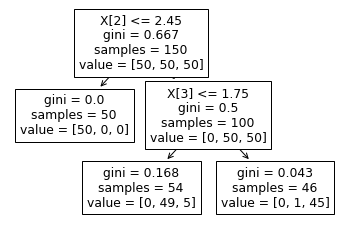

In [9]:
plot_tree(clf)

In [3]:
dot = """digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;

}'"""
    
print(dot)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;

}'


In [ ]:
digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<petal length (cm) &le; 2.45<br/>gini = 0.667<br/>samples = 150<br/>value = [50, 50, 50]<br/>class = setosa>, fillcolor="#ffffff"] ;
1 [label=<gini = 0.0<br/>samples = 50<br/>value = [50, 0, 0]<br/>class = setosa>, fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<petal width (cm) &le; 1.75<br/>gini = 0.5<br/>samples = 100<br/>value = [0, 50, 50]<br/>class = versicolor>, fillcolor="#ffffff"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label=<gini = 0.168<br/>samples = 54<br/>value = [0, 49, 5]<br/>class = versicolor>, fillcolor="#4de88e"] ;
2 -> 3 ;
4 [label=<gini = 0.043<br/>samples = 46<br/>value = [0, 1, 45]<br/>class = virginica>, fillcolor="#843de6"] ;
2 -> 4 ;
}


digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;

}